In [1]:
import os
from time import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import SimpleITK as sitk
import scipy.ndimage as ndimage

import nibabel as nib
import matplotlib.pyplot as plt

import cv2

In [ ]:
num_organ = 13
dropout_rate = 0.3

class ResUNet(nn.Module):
    """
    共9332094个可训练的参数, 九百三十万左右
    """
    def __init__(self, training, inchannel, stage):
        """
        :param training: 标志网络是属于训练阶段还是测试阶段
        :param inchannel 网络最开始的输入通道数量
        :param stage 标志网络属于第一阶段，还是第二阶段
        """
        super().__init__()

        self.training = training
        self.stage = stage

        self.encoder_stage1 = nn.Sequential(
            nn.Conv3d(inchannel, 16, 3, 1, padding=1),
            nn.PReLU(16),
        )

        self.encoder_stage2 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.PReLU(32),

            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.PReLU(32),
        )

        self.encoder_stage3 = nn.Sequential(
            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=2, dilation=2),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=4, dilation=4),
            nn.PReLU(64),
        )

        self.encoder_stage4 = nn.Sequential(
            nn.Conv3d(128, 128, 3, 1, padding=3, dilation=3),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=4, dilation=4),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=5, dilation=5),
            nn.PReLU(128),
        )

        self.decoder_stage1 = nn.Sequential(
            nn.Conv3d(128, 256, 3, 1, padding=1),
            nn.PReLU(256),

            nn.Conv3d(256, 256, 3, 1, padding=1),
            nn.PReLU(256),

            nn.Conv3d(256, 256, 3, 1, padding=1),
            nn.PReLU(256),
        )

        self.decoder_stage2 = nn.Sequential(
            nn.Conv3d(128 + 64, 128, 3, 1, padding=1),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1),
            nn.PReLU(128),
        )

        self.decoder_stage3 = nn.Sequential(
            nn.Conv3d(64 + 32, 64, 3, 1, padding=1),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.PReLU(64),
        )

        self.decoder_stage4 = nn.Sequential(
            nn.Conv3d(32 + 16, 32, 3, 1, padding=1),
            nn.PReLU(32),
        )

        self.down_conv1 = nn.Sequential(
            nn.Conv3d(16, 32, 2, 2),
            nn.PReLU(32)
        )

        self.down_conv2 = nn.Sequential(
            nn.Conv3d(32, 64, 2, 2),
            nn.PReLU(64)
        )

        self.down_conv3 = nn.Sequential(
            nn.Conv3d(64, 128, 2, 2),
            nn.PReLU(128)
        )

        self.down_conv4 = nn.Sequential(
            nn.Conv3d(128, 256, 3, 1, padding=1),
            nn.PReLU(256)
        )

        self.up_conv2 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, 2, 2),
            nn.PReLU(128)
        )

        self.up_conv3 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, 2, 2),
            nn.PReLU(64)
        )

        self.up_conv4 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, 2, 2),
            nn.PReLU(32)
        )

        self.map = nn.Sequential(
            nn.Conv3d(32, num_organ + 1, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        long_range1 = self.encoder_stage1(inputs) + inputs

        short_range1 = self.down_conv1(long_range1)

        long_range2 = self.encoder_stage2(short_range1) + short_range1
        long_range2 = F.dropout(long_range2, dropout_rate, self.training)

        short_range2 = self.down_conv2(long_range2)

        long_range3 = self.encoder_stage3(short_range2) + short_range2
        long_range3 = F.dropout(long_range3, dropout_rate, self.training)

        short_range3 = self.down_conv3(long_range3)

        long_range4 = self.encoder_stage4(short_range3) + short_range3
        long_range4 = F.dropout(long_range4, dropout_rate, self.training)

        short_range4 = self.down_conv4(long_range4)

        outputs = self.decoder_stage1(long_range4) + short_range4
        outputs = F.dropout(outputs, dropout_rate, self.training)

        short_range6 = self.up_conv2(outputs)

        outputs = self.decoder_stage2(torch.cat([short_range6, long_range3], dim=1)) + short_range6
        outputs = F.dropout(outputs, dropout_rate, self.training)

        short_range7 = self.up_conv3(outputs)

        outputs = self.decoder_stage3(torch.cat([short_range7, long_range2], dim=1)) + short_range7
        outputs = F.dropout(outputs, dropout_rate, self.training)

        short_range8 = self.up_conv4(outputs)

        outputs = self.decoder_stage4(torch.cat([short_range8, long_range1], dim=1)) + short_range8

        outputs = self.map(outputs)

        # 返回概率图
        return outputs


# 定义最终的级连3D FCN
class Net(nn.Module):
    def __init__(self, training):
        super().__init__()

        self.training = training

        self.stage1 = ResUNet(training=training, inchannel=1, stage='stage1')
        # self.stage2 = ResUNet(training=training, inchannel=num_organ + 2, stage='stage2')

    def forward(self, inputs):
        """
        首先将输入数据在轴向上缩小一倍，然后送入第一阶段网络中
        得到一个粗糙尺度下的分割结果
        然后将原始尺度大小的数据与第一步中得到的分割结果进行拼接，共同送入第二阶段网络中
        得到最终的分割结果
        共18656348个可训练的参数，一千八百万左右
        """
        # 首先将输入缩小一倍
        inputs_stage1 = F.upsample(inputs, (48, 128, 128), mode='trilinear')

        # 得到第一阶段的结果
        output_stage1 = self.stage1(inputs_stage1)
        output_stage1 = F.upsample(output_stage1, (48, 256, 256), mode='trilinear')

        # 将第一阶段的结果与原始输入数据进行拼接作为第二阶段的输入
        # inputs_stage2 = torch.cat((output_stage1, inputs), dim=1)

        # 得到第二阶段的结果
        # output_stage2 = self.stage2(inputs_stage2)

        # if self.training is True:
        #     return output_stage1, output_stage2
        # else:
        #     return output_stage2
        return output_stage1

In [ ]:
val_ct_dir = 'D:/skripsi/Abdomen/RawData/Training/img'
organ_pred_dir = 'D:/skripsi/'

module_dir = 'D:/skripsi/weights2/120-0.513-0.540.pth'

In [ ]:
# label_map = {
#     1: 'spleen',
#     2: 'right kidney',
#     3: 'left kidney',
#     4: 'gallbladder',
#     5: 'esophagus',
#     6: 'liver',
#     7: 'stomach',
#     8: 'aorta',
#     9: 'inferior vena cava',
#     10: 'portal vein and splenic vein',
#     11: 'pancreas',
#     12: 'right adrenal gland',
#     13: 'left adrenal gland'
# }

In [ ]:
net = Net(training=False)
net.load_state_dict(torch.load(module_dir))
net.eval()

Net(
  (stage1): ResUNet(
    (encoder_stage1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=16)
    )
    (encoder_stage2): Sequential(
      (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=32)
      (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): PReLU(num_parameters=32)
    )
    (encoder_stage3): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=64)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2), dilation=(2, 2, 2))
      (3): PReLU(num_parameters=64)
      (4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4), dilation=(4, 4, 4))
      (5): PReLU(num_parameters=64)
    )
    (encoder_stage4): Sequential(
      (0): Conv3d(128, 128, kernel_size=(3, 3, 3)

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

upper = 350
lower = -upper
down_scale = 0.5
size = 48
slice_thickness = 3


organ_list = [
    'spleen',
    'right kidney',
    'left kidney',
    'gallbladder',
    'esophagus',
    'liver',
    'stomach',
    'aorta',
    'inferior vena cava',
    'portal vein and splenic vein',
    'pancreas',
    'right adrenal gland',
    'left adrenal gland',
]

In [ ]:
color_map = [
    [0, 0, 0],          # background
    [128, 0, 0],        # spleen
    [0, 128, 0],        # right kidney
    [0, 0, 128],        # left kidney
    [128, 128, 0],      # gallbladder
    [0, 128, 128],      # esophagus
    [128, 0, 128],      # liver
    [64, 0, 0],         # stomach
    [192, 0, 0],        # aorta
    [64, 128, 0],       # inferior vena cava
    [192, 128, 0],      # portal vein and splenic vein
    [64, 0, 128],       # pancreas
    [192, 0, 128],       # right adrenal gland
    [64, 128, 128],     # left adrenal gland
]

lut = np.zeros((256, 1, 3), dtype=np.uint8)
for i in range(len(color_map)):
    lut[i] = color_map[i]

In [ ]:
def show_image(ct_array_original, pred_seg, aspect_ratio, new_dims):
    fig, axs = plt.subplots(1,3)
    fig.suptitle('Scan Array w/ Proper Aspect Ratio (Middle Slices)')
    
    alpha = 0.5
    
    ct_slice = ct_array_original[ct_array_original.shape[0]//2, :, :]
    ct_slice = cv2.normalize(ct_slice, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # ct_slice = cv2.cvtColor(ct_slice, cv2.COLOR_GRAY2RGB)
    ct_slice = np.stack((ct_slice,)*3, axis = -1)

    seg_slice = pred_seg[pred_seg.shape[0]//2, :, :]
    seg_slice = cv2.normalize(seg_slice, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    seg_slice = cv2.applyColorMap(seg_slice, cv2.COLORMAP_JET)
    
    overlay_coronal = cv2.addWeighted(ct_slice, 1-alpha, seg_slice, alpha, 0)
    overlay_coronal = cv2.resize(overlay_coronal, (new_dims[2], new_dims[1]))
    
    ct_slice = ct_array_original[:, ct_array_original.shape[1]//2, :]
    ct_slice = cv2.normalize(ct_slice, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    ct_slice = cv2.flip(ct_slice, 0)
    # ct_slice = cv2.cvtColor(ct_slice, cv2.COLOR_GRAY2RGB)
    ct_slice = np.stack((ct_slice,)*3, axis = -1)

    seg_slice = pred_seg[:, ct_array_original.shape[1]//2, :]
    seg_slice = cv2.normalize(seg_slice, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    seg_slice = cv2.flip(seg_slice, 0)
    seg_slice = cv2.applyColorMap(seg_slice, cv2.COLORMAP_JET)
    
    overlay_sagittal = cv2.addWeighted(ct_slice, 1-alpha, seg_slice, alpha, 0)
    overlay_sagittal = cv2.resize(overlay_sagittal, (new_dims[2], new_dims[0]))
    
    ct_slice = ct_array_original[:, :, ct_array_original.shape[2]//2]
    ct_slice = cv2.normalize(ct_slice, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    ct_slice = cv2.flip(ct_slice, 0)
    # ct_slice = cv2.cvtColor(ct_slice, cv2.COLOR_GRAY2RGB)
    ct_slice = np.stack((ct_slice,)*3, axis = -1)

    seg_slice = pred_seg[:, :, ct_array_original.shape[2]//2]
    seg_slice = cv2.normalize(seg_slice, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    seg_slice = cv2.flip(seg_slice, 0)
    seg_slice = cv2.applyColorMap(seg_slice, cv2.COLORMAP_JET)
    
    overlay_axial = cv2.addWeighted(ct_slice, 1-alpha, seg_slice, alpha, 0)
    overlay_axial = cv2.resize(overlay_axial, (new_dims[1], new_dims[0]))
    

#     cv2.imshow("Overlay", overlay)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    axs[0].imshow(overlay_coronal)
    axs[1].imshow(overlay_sagittal)
    axs[2].imshow(overlay_axial)
    fig.tight_layout()
    plt.show()

The new scan dimensions are:  (373, 373, 444)


C:\Users\johan\anaconda3\envs\FlaskAi\lib\site-packages\torch\nn\functional.py:3742: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(148, 512, 512)


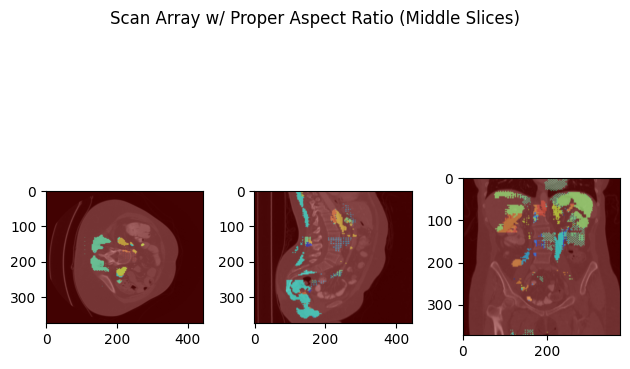

In [ ]:
file = "img0008.nii.gz"

ct = sitk.ReadImage(os.path.join(val_ct_dir, file), sitk.sitkInt16)

ct_nib = nib.load(os.path.abspath(os.path.join(val_ct_dir, file)))
pix_dim = ct_nib.header["pixdim"][1:4]
aspect_ratio = [pix_dim[1]/pix_dim[2],pix_dim[0]/pix_dim[2],pix_dim[0]/pix_dim[1]]

ct_array_original = ct_nib.get_fdata()
ct_array_original = np.transpose(ct_array_original, (2, 0, 1))
# ct_array = sitk.GetArrayFromImage(ct)

original_shape = ct_array_original.shape

new_dims = np.multiply(ct_nib.get_fdata().shape, pix_dim)
new_dims = (round(new_dims[0]),round(new_dims[1]),round(new_dims[2]))
print('The new scan dimensions are: ', new_dims)

ct_array = ndimage.zoom(ct_array_original, (ct.GetSpacing()[-1] / slice_thickness, down_scale, down_scale), order=3)

# slice and sample in the axial direction
flag  =  False
start_slice = 0
end_slice = start_slice + size - 1
ct_array_list = []

while end_slice <= ct_array.shape[0] - 1:
    ct_array_list.append(ct_array[start_slice:end_slice + 1, :, :])

    start_slice = end_slice + 1
    end_slice = start_slice + size - 1

# When it is not divisible, take the last block in reverse
if end_slice is not ct_array.shape[0] - 1:
    flag = True
    count = ct_array.shape[0] - start_slice
    ct_array_list.append(ct_array[-size:, :, :])
    
outputs_list = []
with torch.no_grad():
    for ct_array in ct_array_list:

        ct_tensor = torch.FloatTensor(ct_array)
        ct_tensor = ct_tensor.unsqueeze(dim=0)
        ct_tensor = ct_tensor.unsqueeze(dim=0)

        outputs = net(ct_tensor)
        outputs = outputs.squeeze()

        outputs_list.append(outputs.cpu().detach().numpy())
        del outputs

# Start splicing results after execution
pred_seg = np.concatenate(outputs_list[0:-1], axis=1)
if flag is False:
    pred_seg = np.concatenate([pred_seg, outputs_list[-1]], axis=1)
else:
    pred_seg = np.concatenate([pred_seg, outputs_list[-1][:, -count:, :, :]], axis=1)


pred_seg = torch.FloatTensor(pred_seg).unsqueeze(dim=0)
pred_seg = F.interpolate(pred_seg, original_shape, mode='trilinear').squeeze().detach().numpy()
pred_seg = np.argmax(pred_seg, axis=0)
pred_seg = np.round(pred_seg).astype(np.uint8)

print(pred_seg.shape)

show_image(ct_array_original, pred_seg, aspect_ratio, new_dims)

pred_seg = sitk.GetImageFromArray(pred_seg)

pred_seg.SetDirection(ct.GetDirection())
pred_seg.SetOrigin(ct.GetOrigin())
pred_seg.SetSpacing(ct.GetSpacing())

# sitk.WriteImage(pred_seg, os.path.join(organ_pred_dir, file.replace('img', 'organ')))
del pred_seg